In [1]:
!pip install fairlearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from fairlearn.metrics import MetricFrame
from fairlearn.reductions import ExponentiatedGradient, DemographicParity


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

df = pd.read_csv(
    url,
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
)

df.dropna(inplace=True)


In [3]:
df["income"] = LabelEncoder().fit_transform(df["income"])  # 0: <=50K, 1: >50K
df["sex"] = LabelEncoder().fit_transform(df["sex"])        # 0: Female, 1: Male


In [4]:
categorical_cols = df.select_dtypes(include="object").columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [5]:
X = df.drop("income", axis=1)
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
baseline_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000))
])

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)


In [7]:
mf = MetricFrame(
    metrics=accuracy_score,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test["sex"]
)

print("Overall Accuracy:", mf.overall)
print("\nAccuracy by Gender:")
print(mf.by_group)


Overall Accuracy: 0.8572086596038692

Accuracy by Gender:
sex
0    0.918627
1    0.827445
Name: accuracy_score, dtype: float64


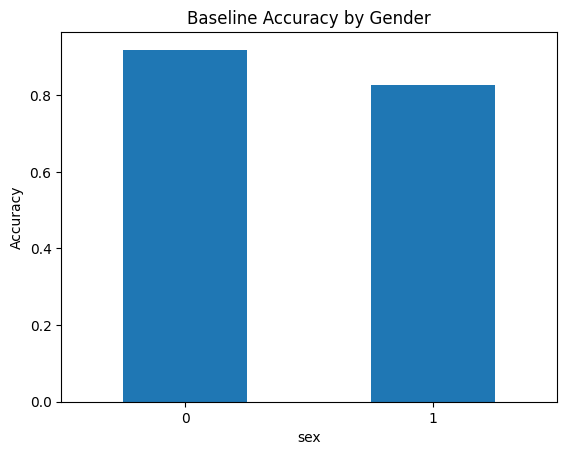

In [8]:
mf.by_group.plot(kind="bar")
plt.title("Baseline Accuracy by Gender")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.show()


In [9]:
constraint = DemographicParity()

fair_model = ExponentiatedGradient(
    estimator=baseline_model,
    constraints=constraint,
    sample_weight_name="lr__sample_weight"
)

fair_model.fit(
    X_train,
    y_train,
    sensitive_features=X_train["sex"]
)


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x7d2650be4e90>,
                      estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                ('lr',
                                                 LogisticRegression(max_iter=5000))]),
                      nu=np.float64(0.0010984590365855037),
                      sample_weight_name='lr__sample_weight')

In [10]:
y_fair_pred = fair_model.predict(X_test)

mf_fair = MetricFrame(
    metrics=accuracy_score,
    y_true=y_test,
    y_pred=y_fair_pred,
    sensitive_features=X_test["sex"]
)

print("Fair Model Overall Accuracy:", mf_fair.overall)
print("\nFair Model Accuracy by Gender:")
print(mf_fair.by_group)


Fair Model Overall Accuracy: 0.8358667280822969

Fair Model Accuracy by Gender:
sex
0    0.891345
1    0.808981
Name: accuracy_score, dtype: float64


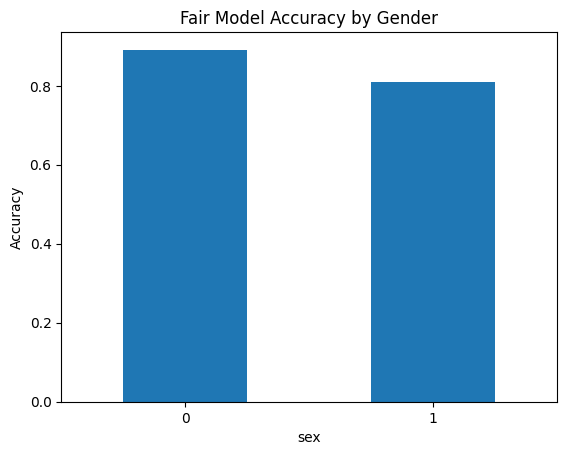

In [11]:
mf_fair.by_group.plot(kind="bar")
plt.title("Fair Model Accuracy by Gender")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.show()


In [12]:
results_df = pd.DataFrame({
    "Actual_Income": y_test.values,
    "Baseline_Prediction": y_pred,
    "Fair_Prediction": y_fair_pred,
    "Gender": X_test["sex"].map({0: "Female", 1: "Male"})
})

# Accuracy flags
results_df["Baseline_Correct"] = (
    results_df["Actual_Income"] == results_df["Baseline_Prediction"]
).astype(int)

results_df["Fair_Correct"] = (
    results_df["Actual_Income"] == results_df["Fair_Prediction"]
).astype(int)

results_df.head()


,Actual_Income,Baseline_Prediction,Fair_Prediction,Gender,Baseline_Correct,Fair_Correct
14160,0,0,0,Female,1,1
27048,0,0,1,Female,1,0
28868,1,1,1,Male,1,1
5667,0,0,0,Female,1,1
7827,0,0,0,Male,1,1


In [13]:
results_df.to_csv("fairness_results.csv", index=False)


In [14]:
import os
os.listdir()


['.config', 'fairness_results.csv', 'sample_data']

In [15]:
from google.colab import files
files.download("fairness_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>